To-do:

1. create single symmetrical co-occurrence matrix (with general semantic embeddings)
2. determine target/landmark pairings from this matrix 
3. visualize object clusters
4. compare clusters across language models
5. design room

In [1]:
import numpy as np
import pandas as pd
import gzip
import fastparquet
import matplotlib.pyplot as plt
import tensorflow as tf
import gensim.downloader as api

In [2]:
model = api.load('conceptnet-numberbatch-17-06-300')

In [5]:
# finalize object list
objects = pd.read_excel('post_objects.xlsx', header=None)

In [17]:
# create cooccurrence matrix 
cooccur = np.zeros((len(objects), len(objects)))

for i in range(len(objects)):
    
    for j in range(len(objects)):
        
        cooccur[i,j] = model.similarity(objects.iloc[i][0],objects.iloc[j][0])

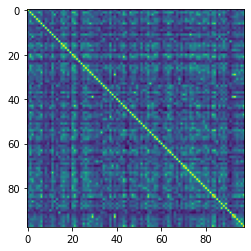

In [19]:
# cluster correlation matrix

In [11]:
# determine target landmark pairings
num_targets = []

for i in range(len(landmarks)):
    num_targets.append(sum(pair.landmark == landmarks[i]))
    
print(num_targets)

[9, 2, 15, 13, 4, 9]


In [12]:
pair['target'][pair['landmark']==landmarks[5]]

11          crab
15           fan
23    ingredient
24          iron
25        kettle
27         maker
33           oil
36           pan
42           pot
Name: target, dtype: object

In [13]:
# design room

0    counter
1      floor
2      table
3      shelf
4       wall
5      stove
Name: landmark, dtype: object